In [0]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.3.1
nvidia driver : 418.67
torch cuda    : 10.1.243 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [0]:
printm() 

Gen RAM Free: 21.6 GB  | Proc size: 6.9 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
#!pip install tensorflow-addons

In [0]:
from google.colab import drive
drive.mount('/content/drive')
! rm -r /content/sample_data
! cp -a '/content/drive/My Drive/cityscapes/.' '/content'

# Data

In [0]:
%tensorflow_version 2.x
%load_ext tensorboard
import tensorflow as tf
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import skimage
from tensorflow.keras import backend, layers, models
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from collections import namedtuple

# Taken from cityscapesscripts\helpers\labels.py
Label = namedtuple( 'Label' , [
    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class
    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.
    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!
    'category'    , # The name of the category that this label belongs to
    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.
    'hasInstances', # Whether this label distinguishes between single instances or not
    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not
    'color'       , # The color of this label
    ] )
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]
LABEL_DICTIONARY   = { label.trainId : label for label in reversed(labels) }

Creating data-pipeline

In [0]:
CLASSES = 20 # trainId from 0 to 18 + unlabeled 255 as 19
IMAGE_WIDTH = 2048
IMAGE_HEIGHT = 1024
BATCH_SIZE = 2
FINE_TRAIN_DATASET_SIZE = 2975
COARSE_TRAIN_DATASET_SIZE = 20000
VAL_DATASET_SIZE = 500

def color_mask(grayscale_mask):
  def grayscale_value_to_rgb_tuple(pixel): 
    if pixel >= CLASSES-1:
      pixel = 255
    rgb_tuple = LABEL_DICTIONARY[pixel].color
    return rgb_tuple
  fun = np.vectorize(grayscale_value_to_rgb_tuple)
  rgb_tuple_mask = fun(grayscale_mask)
  color_mask = np.dstack([rgb_tuple_mask[0], rgb_tuple_mask[1], rgb_tuple_mask[2]])
  return color_mask.astype(np.uint8)

@tf.function
def augmentation(input_image, true_mask):
  stacked_image = tf.keras.backend.concatenate([input_image, true_mask], axis=2)
  #if tf.random.uniform(()) < 0.99:
  #  angle = tf.random.uniform(minval=-0.05, maxval=0.05, dtype=tf.dtypes.float32, shape=[])
  #  stacked_image = tfa.image.rotate(stacked_image, angle, interpolation='NEAREST', name=None)
  if tf.random.uniform(()) < 0.50:
    zoom = tf.random.uniform(minval=0.75, maxval=1.0, dtype=tf.dtypes.float32, shape=[])
    stacked_image = tf.image.random_crop(stacked_image, size=[IMAGE_HEIGHT*zoom, IMAGE_WIDTH*zoom, 4])
    stacked_image = tf.image.resize(stacked_image, [IMAGE_HEIGHT, IMAGE_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  if tf.random.uniform(()) < 0.50:
    stacked_image = tf.image.flip_left_right(stacked_image)
  input_image = stacked_image[:,:,0:3]
  true_mask = stacked_image[:,:,3:4]
  return input_image, true_mask

@tf.function
def normalize(input_image, true_mask):
  true_mask = tf.cast(true_mask, tf.float32)
  # Clip 0-255 -> 0-19
  true_mask = tf.clip_by_value(true_mask, clip_value_min=0, clip_value_max=CLASSES-1) 
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, true_mask

def parse_example_function(example_proto):
  """Dekodowanie danych z TFRecords"""
  feature_description = {
    'image/encoded': tf.io.FixedLenFeature((), tf.string, default_value=''),
    'image/filename': tf.io.FixedLenFeature((), tf.string, default_value=''),
    'image/format': tf.io.FixedLenFeature((), tf.string, default_value='jpeg'),
    'image/height': tf.io.FixedLenFeature((), tf.int64, default_value=0),
    'image/width': tf.io.FixedLenFeature((), tf.int64, default_value=0),
    'image/segmentation/class/encoded': tf.io.FixedLenFeature((), tf.string, default_value=''),
    'image/segmentation/class/format': tf.io.FixedLenFeature((), tf.string, default_value='png'),
  }
  return tf.io.parse_single_example(example_proto, feature_description)

@tf.function
def parse_function(example, data_augmentation):
  parsed_example = parse_example_function(example)
  input_image = tf.io.decode_jpeg(parsed_example['image/encoded'], channels=3)
  true_mask = tf.io.decode_png(parsed_example['image/segmentation/class/encoded'], channels=1) 
  if data_augmentation==True:
    input_image, true_mask = augmentation(input_image, true_mask)
  input_image, true_mask = normalize(input_image, true_mask)
  return input_image, true_mask

def make_dataset(file_pattern, batch_size, data_augmentation=True):
  files = tf.data.Dataset.list_files(file_pattern=file_pattern)
  dataset = tf.data.TFRecordDataset(files)
  if data_augmentation:
    dataset = dataset.shuffle(buffer_size=FINE_TRAIN_DATASET_SIZE)
  dataset = dataset.map(lambda example: parse_function(example, data_augmentation), num_parallel_calls=2)
  dataset = dataset.batch(batch_size=batch_size).repeat()
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

validation_dataset = make_dataset('val-fine-0000*-of-00002.tfrecord', BATCH_SIZE, data_augmentation=False)
#train_coarse_dataset = make_dataset('train-coarse-0000*-of-00002.tfrecord', BATCH_SIZE, data_augmentation=True)
train_fine_dataset = make_dataset('train-fine-0000*-of-00002.tfrecord', BATCH_SIZE, data_augmentation=True)

Reading 3 examples from data pipeline



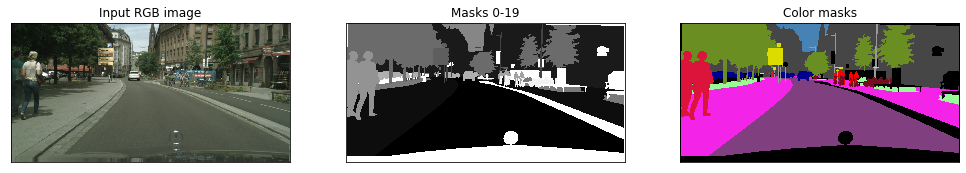

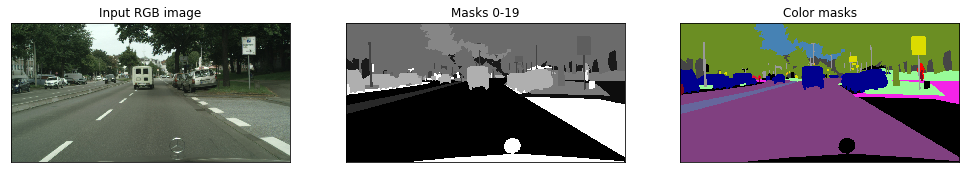

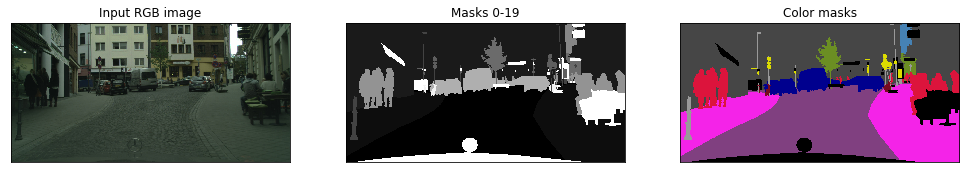

In [0]:
for example in train_fine_dataset.take(3):
  fig = plt.figure(figsize=(17,20))
  plt.subplot(1,3,1)
  plt.title('Input RGB image')
  plt.xticks([])
  plt.yticks([])
  plt.imshow(example[0][0])
  plt.subplot(1,3,2)
  plt.title('Masks 0-19')
  plt.xticks([])
  plt.yticks([])
  true_mask = example[1][0,:,:,0]
  plt.imshow(true_mask, cmap='gray')
  plt.subplot(1,3,3)
  plt.title('Color masks')
  plt.xticks([])
  plt.yticks([])
  color_true_mask = color_mask(true_mask)
  plt.imshow(color_true_mask) 
  plt.show()

# Models

## Unet MobileNet V2  (val. acc 0.91, val. mIOU 0.60)

Big and slow model due to Conv2DTranspose, which takes up most of the computational time.

Batch size = 3



In [0]:
# MobileNetv2: https://arxiv.org/pdf/1801.04381.pdf

feature_extractor = tf.keras.applications.MobileNetV2(input_shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], include_top=False, alpha=1.0)
output_layer_names = [
    'block_1_expand_relu', # None, 1024, 512, 96 -> level 2
    'block_3_expand_relu', # None, 512, 256, 144 -> level 3
    'block_6_expand_relu', # None, 256, 128, 192 -> level 4
    'block_13_expand_relu',# None, 128, 64, 576 -> level 5
    'block_16_project',    # None, 64, 32, 320 -> level 6
]
feature_extractor_output_layers = [feature_extractor.get_layer(name).output for name in output_layer_names]

def upsample(filters, activation=None, last=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, kernel_size=(3,3), strides=2, padding='same', 
                                             kernel_initializer=initializer, use_bias=False, activation=activation))
  if not last:
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())
  return result

# Top-down
level6 = feature_extractor_output_layers[-1]
level5 = upsample(filters=512)(level6)
level5 = tf.keras.layers.concatenate([level5, feature_extractor_output_layers[-2]])
level4 = upsample(filters=256)(level5)
level4 = tf.keras.layers.concatenate([level4, feature_extractor_output_layers[-3]])
level3 = upsample(filters=128)(level4)
level3 = tf.keras.layers.concatenate([level3, feature_extractor_output_layers[-4]])
level2 = upsample(filters=64)(level3)
level2 = tf.keras.layers.concatenate([level2, feature_extractor_output_layers[-5]])
output_layer = upsample(filters=CLASSES, activation='softmax', last=True)(level2)

class MeanIoU(tf.keras.metrics.MeanIoU):
    """MeanIoU for sparse_categorical_crossentropy"""
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

model = tf.keras.Model(inputs=feature_extractor.input, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', MeanIoU(num_classes=CLASSES, name='mIOU')])

model.summary(line_length=150)
#tf.keras.utils.plot_model(model, show_shapes=True, to_file='Unet MobileNet V2.png')

## Unet Large MobileNet V3  (val. acc 0.86, val. mIOU 0.39)




Just like Unet MobileNet V2: big and slow model due to Conv2DTranspose. Worse accuracy then Unet MobileNet V2.

Batch size 3

![alt text](https://camo.githubusercontent.com/a07fc07bdc037f125e0e6671edbc32d26c33edcc/68747470733a2f2f692e696d6775722e636f6d2f397757453647502e706e67)
![alt text](https://1.bp.blogspot.com/-qMBHklyOfic/XcxKvHgiB8I/AAAAAAAAE8A/osT1RxwyqPY7bE_x7vsyYTYiIt7QSn0hQCEwYBhgL/s1600/image1.png)


Theres no MobileNet V3 in Keras model zoo.

MobileNet V3 paper: https://arxiv.org/pdf/1905.02244v4.pdf

In [0]:
class MobileNetV3:
  def __init__(self, shape, pooling_type):
    self.shape = shape

  def build_large(self):
    inputs = layers.Input(shape=self.shape)
    x = layers.Conv2D(16, (3, 3), padding="same", strides=(2, 2))(inputs)
    x = layers.BatchNormalization(axis=-1)(x)
    x = self._activation(x, "HS")
    # Bottleneck blocks
    x,   _, _, _ = self._bneck(x, 16, (3, 3), expansion=16, strides=1, squeeze=False, at="RE")
    x, c_1, _, _ = self._bneck(x, 24, (3, 3), expansion=64, strides=2, squeeze=False, at="RE") # Expansion layer - C1 (level2)
    x,   _, _, _ = self._bneck(x, 24, (3, 3), expansion=72, strides=1, squeeze=False, at="RE")
    x, c_2, _, _ = self._bneck(x, 40, (5, 5), expansion=72, strides=2, squeeze=True, at="RE") # Expansion layer - C2 (level3)
    x,   _, _, _ = self._bneck(x, 40, (5, 5), expansion=120, strides=1, squeeze=True, at="RE")
    x,   _, _, _ = self._bneck(x, 40, (5, 5), expansion=120, strides=1, squeeze=True, at="RE")
    x, c_3, _, _ = self._bneck(x, 80, (3, 3), expansion=240, strides=2, squeeze=False, at="HS") # Expansion layer - C3  (level4)
    x,   _, _, _ = self._bneck(x, 80, (3, 3), expansion=200, strides=1, squeeze=False, at="HS")
    x,   _, _, _ = self._bneck(x, 80, (3, 3), expansion=184, strides=1, squeeze=False, at="HS")
    x,   _, _, _ = self._bneck(x, 80, (3, 3), expansion=184, strides=1, squeeze=False, at="HS")
    x,   _, _, _ = self._bneck(x, 112, (3, 3), expansion=480, strides=1, squeeze=True, at="HS")
    x,   _, _, _ = self._bneck(x, 112, (3, 3), expansion=672, strides=1, squeeze=True, at="HS")
    x, c_4, _, _ = self._bneck(x, 160, (5, 5), expansion=672, strides=2, squeeze=True, at="HS") # Expansion layer - C4  (level5)
    x,   _, _, _ = self._bneck(x, 160, (5, 5), expansion=960, strides=1, squeeze=True, at="HS")
    x,   _, _, _ = self._bneck(x, 160, (5, 5), expansion=960, strides=1, squeeze=True, at="HS")
    x = layers.Conv2D(960, (1, 1), padding="same", strides=(1, 1))(x)
    c_5 = self._activation(x, "HS") # C5  (level6)
    model = models.Model(inputs, [c_1, c_2, c_3, c_4, c_5], name="mobilenet_v3_feature_extractor")
    return model

  def _bneck(self, x, filters, kernel, expansion, strides, squeeze, at):
    x_copy = x
    input_shape = backend.int_shape(x)
    tchannel = int(expansion)
    cchannel = int(filters)
    r = strides == 1 and input_shape[3] == filters
    # Expansion convolution
    exp_x = layers.Conv2D(tchannel, (1, 1), padding="same", strides=(1, 1))(x)
    exp_x = layers.BatchNormalization(axis=-1)(exp_x)
    exp_x = self._activation(exp_x, at)
    # Depthwise convolution
    dep_x = layers.DepthwiseConv2D(kernel, strides=(strides, strides), depth_multiplier=1, padding="same")(exp_x)
    dep_x = layers.BatchNormalization(axis=-1)(dep_x)
    dep_x = self._activation(dep_x, at)
    # Squeeze
    if squeeze:
        dep_x = self._squeeze(dep_x)
    # Projection convolution
    pro_x = layers.Conv2D(cchannel, (1, 1), strides=(1, 1), padding="same")(dep_x)
    pro_x = layers.BatchNormalization(axis=-1)(pro_x)
    x = pro_x
    if r:
        x = layers.Add()([pro_x, x_copy])
    return x, exp_x, dep_x, pro_x

  def _squeeze(self, x):
    x_copy = x
    channel = backend.int_shape(x)[-1]
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(channel, activation="relu")(x)
    x = layers.Dense(channel, activation="hard_sigmoid")(x)
    x = layers.Reshape((1, 1, channel))(x)
    x = layers.Multiply()([x_copy, x])
    return x

  def _activation(self, x, at):
    if at == "RE":
        x = backend.relu(x, max_value=6) # ReLU6
    else:
        x = x * backend.relu(x, max_value=6) / 6 # Hard swish
    return x

feature_extractor = MobileNetV3(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
feature_extractor = feature_extractor.build_large()
feature_extractor_output_layers = feature_extractor.outputs

def upsample(filters, activation=None, last=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, kernel_size=(3,3), strides=2, padding='same', 
                                             kernel_initializer=initializer, use_bias=False, activation=activation))
  if not last:
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())
  return result

# Top-down (Keras Functional API)
level6 = feature_extractor_output_layers[-1]
level5 = upsample(filters=512)(level6)
level5 = tf.keras.layers.concatenate([level5, feature_extractor_output_layers[-2]])
level4 = upsample(filters=256)(level5)
level4 = tf.keras.layers.concatenate([level4, feature_extractor_output_layers[-3]])
level3 = upsample(filters=128)(level4)
level3 = tf.keras.layers.concatenate([level3, feature_extractor_output_layers[-4]])
level2 = upsample(filters=64)(level3)
level2 = tf.keras.layers.concatenate([level2, feature_extractor_output_layers[-5]])
output_layer = upsample(filters=CLASSES, activation='softmax', last=True)(level2)

model = tf.keras.Model(inputs=feature_extractor.input, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.summary(line_length=150)
tf.keras.utils.plot_model(model, show_shapes=True, to_file='Unet MobileNet V3.png')

## Lite RASPP Large MobileNet V3 (val. acc 0.84, val. mIOU 0.35)


![alt text](https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/image/1095279435121/1095279435121_1570531639002.jpg)

This model predicts only 256x128 semantic map which is upsampled to 2048x1024 at the end.

Batch size = 5

MobileNet V3 paper: https://arxiv.org/pdf/1905.02244v4.pdf

In [0]:
class MobileNetV3LiteRASPP:
  def __init__(self, shape, n_class):
    self.shape = shape
    self.n_class = n_class

  def build_large(self):
    inputs = layers.Input(shape=self.shape)
    x = layers.Conv2D(16, (3, 3), padding="same", strides=(2, 2))(inputs)
    x = layers.BatchNormalization(axis=-1)(x)
    x = self._activation(x, "HS")
    # Bottleneck blocks
    x, _, _, _ = self._bneck(x, 16, (3, 3), expansion=16, strides=1, squeeze=False, at="RE")
    x, _, _, _ = self._bneck(x, 24, (3, 3), expansion=64, strides=2, squeeze=False, at="RE")
    x, _, _, _ = self._bneck(x, 24, (3, 3), expansion=72, strides=1, squeeze=False, at="RE")
    x, _, _, _ = self._bneck(x, 40, (5, 5), expansion=72, strides=2, squeeze=True, at="RE")
    x, _, _, _ = self._bneck(x, 40, (5, 5), expansion=120, strides=1, squeeze=True, at="RE")
    x_8, _, _, _ = self._bneck(x, 40, (5, 5), expansion=120, strides=1, squeeze=True, at="RE")
    x, _, _, _ = self._bneck(x_8, 80, (3, 3), expansion=240, strides=2, squeeze=False, at="HS")
    x, _, _, _ = self._bneck(x, 80, (3, 3), expansion=200, strides=1, squeeze=False, at="HS")
    x, _, _, _ = self._bneck(x, 80, (3, 3), expansion=184, strides=1, squeeze=False, at="HS")
    x, _, _, _ = self._bneck(x, 80, (3, 3), expansion=184, strides=1, squeeze=False, at="HS")
    x, _, _, _ = self._bneck(x, 112, (3, 3), expansion=480, strides=1, squeeze=True, at="HS")
    x_16, _, _, _ = self._bneck(x, 112, (3, 3), expansion=672, strides=1, squeeze=True, at="HS")

    x = self._segmentation_head(x_16, x_8)
    model = models.Model(inputs, x, name="MobileNetV3LiteRASPP")
    return model

  def _bneck(self, x, filters, kernel, expansion, strides, squeeze, at):
    x_copy = x
    input_shape = backend.int_shape(x)
    tchannel = int(expansion)
    cchannel = int(filters)
    r = strides == 1 and input_shape[3] == filters
    # Expansion convolution
    exp_x = layers.Conv2D(tchannel, (1, 1), padding="same", strides=(1, 1))(x)
    exp_x = layers.BatchNormalization(axis=-1)(exp_x)
    exp_x = self._activation(exp_x, at)
    # Depthwise convolution
    dep_x = layers.DepthwiseConv2D(kernel, strides=(strides, strides), depth_multiplier=1, padding="same")(exp_x)
    dep_x = layers.BatchNormalization(axis=-1)(dep_x)
    dep_x = self._activation(dep_x, at)
    # Squeeze
    if squeeze:
        dep_x = self._squeeze(dep_x)
    # Projection convolution
    pro_x = layers.Conv2D(cchannel, (1, 1), strides=(1, 1), padding="same")(dep_x)
    pro_x = layers.BatchNormalization(axis=-1)(pro_x)
    x = pro_x
    if r:
        x = layers.Add()([pro_x, x_copy])
    return x, exp_x, dep_x, pro_x

  def _segmentation_head(self, x_16, x_8):
    x_copy = x_16
    input_size = x_16.shape
    # First branch
    x_b1 = layers.Conv2D(128, (1, 1), strides=(1, 1), padding="same")(x_16)
    # This is the size we want for the other branch
    sh = x_b1.shape
    x_b1 = layers.BatchNormalization(axis=-1)(x_b1)
    x_b1 = self._activation(x_b1, at="RE")
    # Second branch
    x_b2 = layers.AveragePooling2D(pool_size=(49,49), strides=(16,16), padding='same')(x_16)
    x_b2 = layers.Conv2D(128, (1, 1))(x_b2)
    x_b2 = layers.Activation("sigmoid")(x_b2)
    x_b2 = layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(x_b2)
    # Merging branches 1 and 2
    x = layers.Multiply()([x_b1, x_b2])
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(self.n_class, (1, 1))(x)
    x_b3 = layers.Conv2D(self.n_class, (1, 1))(x_8)
    # Merging merge 1 and branche 3
    x = layers.Add()([x, x_b3])
    if(self.n_class == 1):
        x = layers.Activation("sigmoid")(x)
    else:
        x = layers.Activation("softmax")(x)
    x = layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(x)
    return x

  def _squeeze(self, x):
    x_copy = x
    channel = backend.int_shape(x)[-1]
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(channel, activation="relu")(x)
    x = layers.Dense(channel, activation="hard_sigmoid")(x)
    x = layers.Reshape((1, 1, channel))(x)
    x = layers.Multiply()([x_copy, x])
    return x

  def _activation(self, x, at):
    if at == "RE":
        x = backend.relu(x, max_value=6) # ReLU6
    else:
        x = x * backend.relu(x, max_value=6) / 6 # Hard swish
    return x

mnv3_lite_raspp = MobileNetV3LiteRASPP(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), n_class=CLASSES)
model = mnv3_lite_raspp.build_large()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True, to_file='MobileNetV3 LiteRASPP.png')

## DeepLab V3+ Xception 41 (val. acc. 0.87, val. mIOU 0.52)





This model predicts 512x256 semantic map which is upsampled to 2048x1024 at the end.

Paper: https://arxiv.org/abs/1802.02611

Xception 65 and 41 does not fit in the 16GB VRAM, so I used Xception 41 with smaller number of channels and blocks. 

Batch size = 1

Atrous Spatial Pyramid Pooling - from top to bottom B0-B4 maps
![alt text](https://miro.medium.com/max/1121/0*nnPrlrQAt0bDzIWF)


Xception 65

![alt text](http://lijiancheng0614.github.io/2018/02/27/2018_02_27_DeepLab-v3+/figure3.png)

In [0]:
"""
Taken from:
https://github.com/bonlime/keras-deeplab-v3-plus/blob/master/model.py
"""
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Activation, Concatenate, Add, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.utils import get_source_inputs, get_file
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu

def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """
    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    return x

def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)

def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs

def Deeplabv3(input_shape=(1024, 2048, 3), classes=20, OS=8):
    """ Instantiates the Deeplabv3+ architecture
    # Arguments
        input_shape: shape of input image. format HxWxC
        classes: number of desired classes. 
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    img_input = Input(shape=input_shape)
    if OS == 8:
        entry_block3_stride = 1
        middle_block_rate = 2  # Not mentioned in paper, but required
        exit_block_rates = (2, 4)
        atrous_rates = (12, 24, 36)
    else:
        entry_block3_stride = 2
        middle_block_rate = 1
        exit_block_rates = (1, 2)
        atrous_rates = (6, 12, 18)

    x = Conv2D(32, (3, 3), strides=(2, 2), name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
    x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
    x = Activation('relu')(x)

    x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
    x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
    x = Activation('relu')(x)
    
    # Original Xception 65

    # x = _xception_block(x, [128, 128, 128], 'entry_flow_block1', skip_connection_type='conv', stride=2, depth_activation=False)
    # x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2', skip_connection_type='conv', stride=2,
    #                             depth_activation=False, return_skip=True)
    # x = _xception_block(x, [728, 728, 728], 'entry_flow_block3', skip_connection_type='conv', stride=entry_block3_stride,
    #                     depth_activation=False)
    # for i in range(16):
    #     x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1), 
    #                         skip_connection_type='sum', stride=1, rate=middle_block_rate,
    #                         depth_activation=False)
    # x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1', skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
    #                     depth_activation=False)
    # x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2', skip_connection_type='none', stride=1, rate=exit_block_rates[1],
    #                     depth_activation=True)
    
    # Modified Xception 41

    x = _xception_block(x, [64, 64, 64], 'entry_flow_block1', skip_connection_type='conv', stride=2, depth_activation=False)
    x, skip1 = _xception_block(x, [128, 128, 128], 'entry_flow_block2', skip_connection_type='conv', stride=2,
                                depth_activation=False, return_skip=True)
    x = _xception_block(x, [364, 364, 364], 'entry_flow_block3', skip_connection_type='conv', stride=entry_block3_stride,
                        depth_activation=False)
    for i in range(6): # 16 blocks = Xception 65, 8 blocks = Xception 41 
        x = _xception_block(x, [364, 364, 364], 'middle_flow_unit_{}'.format(i + 1), 
                            skip_connection_type='sum', stride=1, rate=middle_block_rate,
                            depth_activation=False)
    x = _xception_block(x, [364, 512, 512], 'exit_flow_block1', skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                        depth_activation=False)
    x = _xception_block(x, [768, 768, 1024], 'exit_flow_block2', skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                        depth_activation=True)
    
    # branching for Atrous Spatial Pyramid Pooling
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    b4 = K.expand_dims(b4, 1)
    b4 = K.expand_dims(b4, 1)
    b4 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='image_pooling')(b4)
    #b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-3)(b4) # Batch normalization creates error with batch size = 1
    b4 = Activation('relu')(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3], method='bilinear', align_corners=True))(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)
    # rate = 6 (12)
    b1 = SepConv_BN(x, 256, 'aspp1', rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
    # rate = 12 (24)
    b2 = SepConv_BN(x, 256, 'aspp2', rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
    # rate = 18 (36)
    b3 = SepConv_BN(x, 256, 'aspp3', rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

    # concatenate ASPP branches & project
    x = Concatenate()([b4, b0, b1, b2, b3])
    x = Conv2D(256, (1, 1), padding='same', use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    # DeepLab v.3+ decoder
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx, skip1.shape[1:3], method='bilinear', align_corners=True))(x)
    dec_skip1 = Conv2D(48, (1, 1), padding='same', use_bias=False, name='feature_projection0')(skip1)
    dec_skip1 = BatchNormalization(name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
    dec_skip1 = Activation('relu')(dec_skip1)
    x = Concatenate()([x, dec_skip1])
    x = SepConv_BN(x, 256, 'decoder_conv0', depth_activation=True, epsilon=1e-5)
    x = SepConv_BN(x, 256, 'decoder_conv1', depth_activation=True, epsilon=1e-5)
    x = Conv2D(classes, (1, 1), padding='same', name='logits')(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx, size_before3[1:3], method='bilinear', align_corners=True))(x)

    inputs = img_input
    x = tf.keras.layers.Activation('softmax')(x)
    model = Model(inputs, x, name='deeplabv3plus')
    return model

class MeanIoU(tf.keras.metrics.MeanIoU):
    """MeanIoU for sparse_categorical_crossentropy"""
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

model = Deeplabv3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), classes=CLASSES, OS=8)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy',MeanIoU(num_classes=CLASSES)])

model.summary(line_length=250)
#tf.keras.utils.plot_model(model, show_shapes=True, to_file='deeplabv3plus_xception.png')

## DeepLab V3+ Atrous-MobileNet V2 (val. acc 0.85, mIOU 0.44)

Modified MobileNet V2 with altrous convolution.

This model predicts 256x128 semantic map which is upsampled to 2048x1024 at the end.

Batch size = 3?

Paper: https://arxiv.org/abs/1801.04381

![alt text](https://img-blog.csdnimg.cn/20181220125104794.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3UwMTE5NzQ2Mzk=,size_16,color_FFFFFF,t_70)

In [0]:
"""
Taken from:
https://github.com/bonlime/keras-deeplab-v3-plus/blob/master/model.py
"""
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Activation, Concatenate, Add, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.utils import get_source_inputs, get_file
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu

def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """
    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'
    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    return x

def relu6(x):
    return relu(x, max_value=6)

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    # Expand
    x = Conv2D(expansion * in_channels, kernel_size=1, padding='same', use_bias=False, activation=None, name=prefix + 'expand')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'expand_BN')(x)
    x = Activation(relu6, name=prefix + 'expand_relu')(x)
    x_exp = x
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None, use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'depthwise_BN')(x)
    x = Activation(relu6, name=prefix + 'depthwise_relu')(x)
    # Project
    x = Conv2D(pointwise_filters, kernel_size=1, padding='same', use_bias=False, activation=None, name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'project_BN')(x)
    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x]), x_exp
    return x, x_exp

def Deeplabv3(input_shape=(1024, 2048, 3), classes=20):
    """ Instantiates the Deeplabv3+ architecture
    # Arguments
        input_shape: shape of input image. format HxWxC
        classes: number of desired classes. 
    # Returns
        A Keras model instance.
    """
    img_input = Input(shape=input_shape)

    alpha = 1.0
    first_block_filters = _make_divisible(32 * alpha, 8)
    x = Conv2D(first_block_filters, kernel_size=3, strides=(2, 2), padding='same', use_bias=False, name='Conv')(img_input)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
    x = Activation(relu6, name='Conv_Relu6')(x)
    x, _     = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0, skip_connection=False)
    x, _     = _inverted_res_block(x, filters=24, alpha=alpha, stride=2, expansion=6, block_id=1, skip_connection=False)
    x, _     = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2, skip_connection=True)
    x, _     = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3, skip_connection=False)
    # Low Level Features (layer_4/depthwise_output)
    x, LLF   = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4, skip_connection=True)
    x, _     = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5, skip_connection=True)
    x, _     = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=6, skip_connection=False)
    # Using rate instead stride
    x, _     = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2, expansion=6, block_id=7, skip_connection=True)
    x, _     = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2, expansion=6, block_id=8, skip_connection=True)
    x, _     = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2, expansion=6, block_id=9, skip_connection=True)
    x, _     = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2, expansion=6, block_id=10, skip_connection=False)
    x, _     = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2, expansion=6, block_id=11, skip_connection=True)
    x, _     = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2, expansion=6, block_id=12, skip_connection=True)
    x, _     = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2, expansion=6, block_id=13, skip_connection=False)
    x, _     = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4, expansion=6, block_id=14, skip_connection=True)
    x, _     = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4, expansion=6, block_id=15, skip_connection=True)
    # High Level Features (layer_18)
    HLF, _   = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4, expansion=6, block_id=16, skip_connection=False)

    # Atrous Spatial Pyramid Pooling
    b4 = GlobalAveragePooling2D()(HLF)
    b4 = K.expand_dims(b4, 1)
    b4 = K.expand_dims(b4, 1)
    b4 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='image_pooling')(b4)
    #b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    x_size = tf.keras.backend.int_shape(HLF)
    b4 = tf.image.resize(b4, x_size[1:3], method='bilinear')
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(HLF)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)
    b1 = SepConv_BN(HLF, 256, 'aspp1', rate=12, depth_activation=True, epsilon=1e-5)
    b2 = SepConv_BN(HLF, 256, 'aspp2', rate=24, depth_activation=True, epsilon=1e-5)
    b3 = SepConv_BN(HLF, 256, 'aspp3', rate=36, depth_activation=True, epsilon=1e-5)

    # concatenate ASPP branches & project
    HLF = Concatenate()([b4, b0, b1, b2, b3])
    HLF = Conv2D(256, (1, 1), padding='same', use_bias=False, name='concat_projection')(HLF)
    HLF = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(HLF)
    HLF = Activation('relu')(HLF)

    # DeepLab v.3+ decoder
    HLF = tf.image.resize(HLF, LLF.shape[1:3], method='bilinear')
    LLF = Conv2D(48, (1, 1), padding='same', use_bias=False, name='feature_projection0')(LLF)
    LLF = BatchNormalization(name='feature_projection0_BN', epsilon=1e-5)(LLF)
    LLF = Activation('relu')(LLF)
    x = Concatenate()([HLF, LLF])
    x = SepConv_BN(x, 256, 'decoder_conv0', depth_activation=True, epsilon=1e-5)
    x = SepConv_BN(x, 256, 'decoder_conv1', depth_activation=True, epsilon=1e-5)
    x = Conv2D(classes, (1, 1), padding='same', name='logits')(x)
    input_size = tf.keras.backend.int_shape(img_input)
    x = tf.image.resize(x, input_size[1:3], method='bilinear')
    x = tf.keras.layers.Activation('softmax')(x)

    return Model(img_input, x, name='DeepLab-V3-Plus_Atrous-MobileNet-V2')

model = Deeplabv3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), classes=CLASSES)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

class MeanIoU(tf.keras.metrics.MeanIoU):
    """MeanIoU for sparse_categorical_crossentropy"""
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', MeanIoU(num_classes=CLASSES, name='mIOU')])

#model.summary(line_length=150)
tf.keras.utils.plot_model(model, show_shapes=True, to_file='DeepLab-V3-Plus_Atrous-MobileNet-V2.png')

## DeepLab V3+ MobileNet V2 (val. acc. 0.92, val. mIOU 0.68)

Ver 1 with 256x128 LLF: val. acc. 0.91, val. mIOU 0.66

Ver 2 with 512x256 LLF: val. acc. 0.91, val. mIOU 0.60

Ver 3 with 512x256 LLF and transpose conv at the end: val. acc. 0.91, val. mIOU 0.59

**Ver 4 with 512x256 LLF and 2 HLF maps 128x64 64x32: val. acc. 0.92, val. mIOU 0.68** (BEST)

Ver 5 with 512x256 LLF and 2 HLF maps 128x64 64x32, changed block_3_expand_relu to block_2_add: val. acc. 0.92, val. mIOU 0.66

Regular MobileNet V2 as feature extractor.

This model predicts 512x256 semantic map which is upsampled to 2048x1024 at the end.

Batch size = 2

Version 4

![alt text](https://raw.githubusercontent.com/KrzysztofV/Cityscapes-image-segmentation/master/custom_deeplabv3%2B.png)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Activation, Concatenate, Add, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.utils import get_source_inputs, get_file
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu

def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """
    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'
    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    return x


def Deeplabv3(input_shape=(1024, 2048, 3), classes=20):
    """ Instantiates the Deeplabv3+ architecture
    # Arguments
        input_shape: shape of input image. format HxWxC
        classes: number of desired classes. 
    # Returns
        A Keras model instance.
    """
    feature_extractor = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, alpha=1.0)
 
    # Low Level Features Map 512x256x144 # Originally block_6_expand_relu #256x128x192
    LLF = feature_extractor.get_layer('block_3_expand_relu').output 
    # First High Level Features Map 128x64x96 # Originally block_16_project_BN #64x32x320
    HLF = feature_extractor.get_layer('block_12_add').output 
    # Second High Level Features Map 64x32x320
    HLF2 = tf.keras.layers.UpSampling2D((2,2), interpolation='bilinear')(feature_extractor.get_layer('block_16_project_BN').output)
    # Merged HLF
    HLF = tf.keras.layers.Concatenate()([HLF,HLF2])

    # Atrous Spatial Pyramid Pooling
    b4 = GlobalAveragePooling2D()(HLF)
    b4 = K.expand_dims(b4, 1)
    b4 = K.expand_dims(b4, 1)
    b4 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='image_pooling')(b4)
    #b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    HLF_size = tf.keras.backend.int_shape(HLF)
    b4 = tf.keras.layers.UpSampling2D(HLF_size[1:3], interpolation='bilinear')(b4)
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(HLF)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)
    b1 = SepConv_BN(HLF, 256, 'aspp1', rate=12, depth_activation=True, epsilon=1e-5)
    b2 = SepConv_BN(HLF, 256, 'aspp2', rate=24, depth_activation=True, epsilon=1e-5)
    b3 = SepConv_BN(HLF, 256, 'aspp3', rate=36, depth_activation=True, epsilon=1e-5)

    # Concatenate ASPP branches & project
    HLF = Concatenate()([b4, b0, b1, b2, b3])
    HLF = Conv2D(256, (1, 1), padding='same', use_bias=False, name='concat_projection')(HLF)
    HLF = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(HLF)
    HLF = Activation('relu')(HLF)

    # DeepLab v.3+ decoder
    HLF = tf.keras.layers.UpSampling2D((4,4), interpolation='bilinear')(HLF)
    LLF = Conv2D(48, (1, 1), padding='same', use_bias=False, name='feature_projection0')(LLF)
    LLF = BatchNormalization(name='feature_projection0_BN', epsilon=1e-5)(LLF)
    LLF = Activation('relu')(LLF)
    x = Concatenate()([HLF, LLF])
    x = SepConv_BN(x, 256, 'decoder_conv0', depth_activation=True, epsilon=1e-5)
    x = SepConv_BN(x, 256, 'decoder_conv1', depth_activation=True, epsilon=1e-5)
    x = Conv2D(classes, (1, 1), padding='same', name='logits')(x)
    x = tf.keras.layers.UpSampling2D((4,4), interpolation='bilinear')(x)
    x = tf.keras.layers.Activation('softmax')(x)

    return Model(feature_extractor.input, x, name='DeepLab-V3-Plus_MobileNet-V2')

model = Deeplabv3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), classes=CLASSES)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

class MeanIoU(tf.keras.metrics.MeanIoU):
    """MeanIoU for sparse_categorical_crossentropy"""
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', MeanIoU(num_classes=CLASSES, name='mIOU')])

model.summary(line_length=150)
#tf.keras.utils.plot_model(model, show_shapes=True, to_file='DeepLab-V3-Plus_MobileNet-V2.png')

# Train

In [0]:
! rm -r '/content/drive/My Drive/deeplabv3_plus_mnv2_ver4'

In [0]:
train_path = Path('/content/drive/My Drive/deeplabv3_plus_mnv2_ver4')
EPOCH_DIVIDER = 1

logdir = train_path / 'logs' / 'scalars' / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=str(logdir), histogram_freq=1, profile_batch=0)
file_writer = tf.summary.create_file_writer(str(logdir / 'metrics'), max_queue=1)
file_writer.set_as_default()

def learning_rate_scheduler(epoch):
  learning_rate = 0.000025
  # if epoch >= 20:
  #   learning_rate = 0.00005
  return learning_rate
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
#learning_rate_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.00001)

# Printing and writing to metrics learning rate
class print_lr_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    tf.summary.scalar('learning rate', data=self.model.optimizer.lr, step=epoch)
    print ('\nLearning rate: {}\n'.format(tf.keras.backend.eval(self.model.optimizer.lr)))

# Load images for visualization
samples_path = Path('/content/samples/')
images_filenames = os.listdir(str(samples_path))
images_filenames.sort()
TRUE_MASKS = []
INPUT_IMAGES = []
for index in range(0,len(images_filenames),2):
  image_path = samples_path / images_filenames[index]
  true_mask = np.asarray(Image.open(str(image_path), mode='r'))
  TRUE_MASKS.append(true_mask)
for index in range(1,len(images_filenames),2):
  image_path = samples_path / images_filenames[index]
  input_image = np.asarray(Image.open(str(image_path), mode='r'))
  INPUT_IMAGES.append(input_image)

# Process 12 visualization examples and save masks to console, tensorboard and logs catalog
class on_epoch_end_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):  

    loss = logs['loss']
    val_loss = logs['val_loss']
    accuracy = logs['accuracy'] 
    val_accuracy = logs['val_accuracy'] 
    miou = logs['mIOU']
    val_miou = logs['val_mIOU']
    learning_rate = self.model.optimizer.lr.numpy()
    
    # 12 examples
    for index in range(0, len(INPUT_IMAGES)):
      input_image = INPUT_IMAGES[index]
      normalized_input_image = tf.cast(input_image, tf.float32) / 255.0
      true_color_mask = color_mask(TRUE_MASKS[index])
      predicted_masks = model.predict(np.expand_dims(normalized_input_image,0))[0]
      predicted_masks = tf.argmax(predicted_masks, axis=2)
      predicted_color_masks = color_mask(tf.cast(predicted_masks, tf.uint8))

      # Paths
      save_image_path = train_path / 'logs' / 'prediction_samples'
      file_path = save_image_path / str(index) 
      if not os.path.exists(str(file_path)):
        os.makedirs(str(file_path))
      filename = str(epoch+1) + '.jpg'
      file_path = file_path / filename

      # Grid images
      blank_image = np.zeros([IMAGE_HEIGHT, IMAGE_WIDTH, 3], dtype=np.uint8)
      top_images = np.concatenate([blank_image, predicted_color_masks], axis=1)
      bottom_images = np.concatenate([input_image, true_color_mask], axis=1)
      final_image = np.concatenate([top_images, bottom_images], axis=0)
      final_image_pil = Image.fromarray(final_image)

      # Draw titles
      draw = ImageDraw.Draw(final_image_pil)
      font = ImageFont.truetype('/content/Arial.ttf', size=45)
      vis_epoch = (epoch+1.0)/EPOCH_DIVIDER
      
      draw.text((100, 100), 'Model: ' + model.name, fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 200), 'Epoch: ' + str("%.2f" % vis_epoch), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 300), 'Loss: ' + str("%.3f" % loss), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 350), 'Val. loss: ' + str("%.3f" % val_loss), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 400), 'Accuracy: ' + str("%.3f" % accuracy), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 450), 'Val. accuracy: ' + str("%.3f" % val_accuracy), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 500), 'mIOU: ' + str("%.3f" % miou), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 550), 'Val. mIOU: ' + str("%.3f" % val_miou), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 650), 'Learning rate: ' + str(learning_rate), fill='rgb(255, 255, 255)', font=font)
      
      # Save to catalog, metrics and console
      final_image_pil.save(file_path, quality=75)
      final_image_pil_small = final_image_pil.resize((1024, 512), Image.BILINEAR)
      tf.summary.image('Sample ' + str(index), [np.array(final_image_pil_small)], step=epoch+1)
      if index == 0:
        fig = plt.figure(figsize=(10,10))
        plt.title('\nSample Prediction after epoch {}\n'.format(epoch+1))
        plt.imshow(np.asarray(final_image_pil))
        plt.show()

# Save checkpoints
checkpoint_path = train_path / 'ckpt' / 'cp-{epoch:04d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(checkpoint_path), 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Ignore unlabeled (19)
class_weights = []
for i in range(0, CLASSES):
  if i == CLASSES-1:
    class_weights.append((i, 0.0))
  else:
    class_weights.append((i, 1.0))
class_weights = tuple(class_weights)

In [0]:
# Tensorboard inside colab
%tensorboard --logdir '/content/drive/My Drive/1/logs' --port 6008

In [0]:
# Loading last checkpoint
ckpt_path = Path('/content/drive/My Drive/deeplabv3_plus_mnv2_ver3/ckpt')
latest = tf.train.latest_checkpoint(str(ckpt_path))
model.load_weights('/content/drive/My Drive/deeplabv3_plus_mnv2_ver4/ckpt/cp-0019.ckpt', by_name=False)

## Fit

Train for 1487.5 steps, validate for 250.0 steps
Epoch 31/35
1487/1487 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9566 - mIOU: 0.8052
Epoch 00031: saving model to /content/drive/My Drive/deeplabv3_plus_mnv2_ver4/ckpt/cp-0031.ckpt


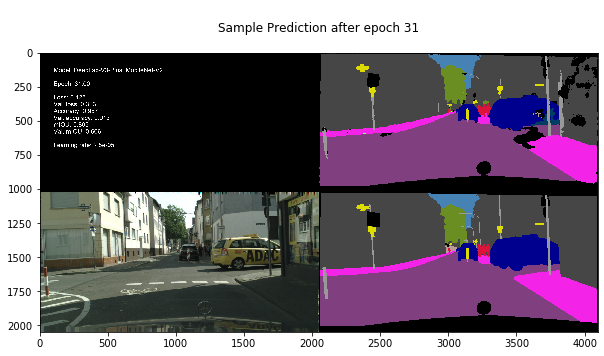


Learning rate: 2.499999936844688e-05

1488/1487 [==============================] - 1511s 1s/step - loss: 0.1251 - accuracy: 0.9566 - mIOU: 0.8052 - val_loss: 0.3132 - val_accuracy: 0.9132 - val_mIOU: 0.6661
Epoch 32/35
1487/1487 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9573 - mIOU: 0.8075
Epoch 00032: saving model to /content/drive/My Drive/deeplabv3_plus_mnv2_ver4/ckpt/cp-0032.ckpt


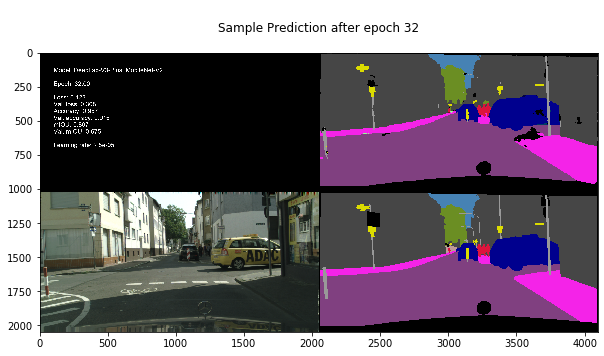


Learning rate: 2.499999936844688e-05

1488/1487 [==============================] - 1509s 1s/step - loss: 0.1227 - accuracy: 0.9573 - mIOU: 0.8075 - val_loss: 0.3079 - val_accuracy: 0.9159 - val_mIOU: 0.6754
Epoch 33/35
1487/1487 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9575 - mIOU: 0.8089
Epoch 00033: saving model to /content/drive/My Drive/deeplabv3_plus_mnv2_ver4/ckpt/cp-0033.ckpt


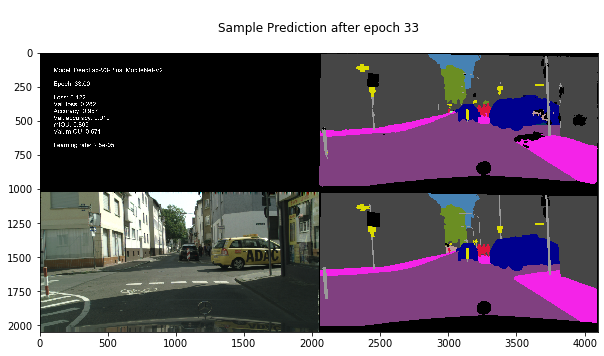


Learning rate: 2.499999936844688e-05

1488/1487 [==============================] - 1511s 1s/step - loss: 0.1222 - accuracy: 0.9575 - mIOU: 0.8089 - val_loss: 0.2819 - val_accuracy: 0.9191 - val_mIOU: 0.6709
Epoch 34/35
1487/1487 [============================>.] - ETA: 0s - loss: 0.1195 - accuracy: 0.9583 - mIOU: 0.8114
Epoch 00034: saving model to /content/drive/My Drive/deeplabv3_plus_mnv2_ver4/ckpt/cp-0034.ckpt


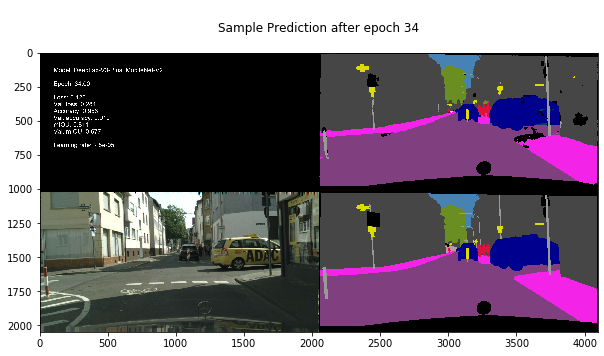


Learning rate: 2.499999936844688e-05

1488/1487 [==============================] - 1513s 1s/step - loss: 0.1196 - accuracy: 0.9583 - mIOU: 0.8112 - val_loss: 0.2843 - val_accuracy: 0.9195 - val_mIOU: 0.6770
Epoch 35/35
1487/1487 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.9582 - mIOU: 0.8096
Epoch 00035: saving model to /content/drive/My Drive/deeplabv3_plus_mnv2_ver4/ckpt/cp-0035.ckpt


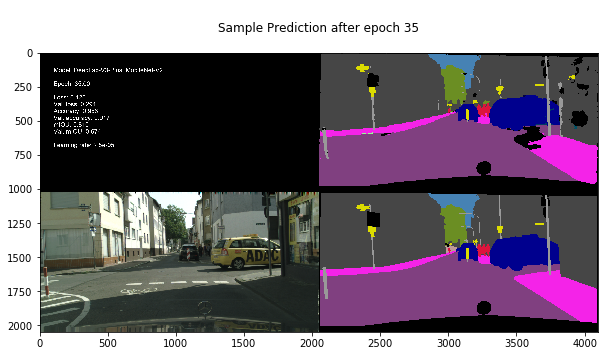


Learning rate: 2.499999936844688e-05

1488/1487 [==============================] - 1509s 1s/step - loss: 0.1200 - accuracy: 0.9582 - mIOU: 0.8096 - val_loss: 0.2943 - val_accuracy: 0.9169 - val_mIOU: 0.6741


In [0]:
history = model.fit(train_fine_dataset, 
                    epochs = 35*EPOCH_DIVIDER,
                    initial_epoch = 30,
                    steps_per_epoch = 2975/BATCH_SIZE/EPOCH_DIVIDER,
                    validation_data = validation_dataset, 
                    validation_steps = 500/BATCH_SIZE,
                    validation_freq = 1, 
                    class_weight=class_weights,
                    callbacks=[tensorboard_callback, 
                               checkpoint_callback, 
                               on_epoch_end_callback(),
                               learning_rate_callback,
                               print_lr_callback()])

In [0]:
from datetime import datetime
for index in range(0, len(INPUT_IMAGES)):
      input_image = INPUT_IMAGES[index]
      normalized_input_image = tf.cast(input_image, tf.float32) / 255.0
      tstart = datetime.now()
      predicted_masks = model.predict(np.expand_dims(normalized_input_image,0))[0]
      tend = datetime.now()
      print(tend-tstart)